Import all necessary libraries

In [1]:
# Importing
# Expand the shape of an array.
from numpy import expand_dims
# Return a new array of given shape and type, filled with zeros.
from numpy import zeros
# Return a new array of given shape and type, filled with ones.
from numpy import ones
from numpy import vstack
# Return a sample (or samples) from the “standard normal” distribution.
from numpy.random import randn
# Return random integers from the “discrete uniform” distribution of the specified datatype
from numpy.random import randint
# Import the MNIST dataset
from tensorflow.keras.datasets.mnist import load_data
# Optimizer that implements the Adam algorithm.
from tensorflow.keras.optimizers import Adam
# Linear stack of layers.
from tensorflow.keras.models import Sequential
# densely-connected NN layer.
from tensorflow.keras.layers import Dense
# Reshapes an output to a certain shape.
from tensorflow.keras.layers import Reshape
# Flattens the input.
from tensorflow.keras.layers import Flatten
# 2D convolution layer (e.g. spatial convolution over images).
from tensorflow.keras.layers import Conv2D
# Transposed convolution layer (sometimes called Deconvolution).
from tensorflow.keras.layers import Conv2DTranspose
# Leaky version of a Rectified Linear Unit.
from tensorflow.keras.layers import LeakyReLU
# Applies Dropout to the input.
from tensorflow.keras.layers import Dropout
# Converts a Keras model to dot format and save to a file.
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot

# Loading and examination of the MNIST dataset

The MNIST dataset is an acronym that stands for the Modified National Institute of Standards and Technology dataset.

It is a dataset of 70,000 small square 28×28 pixel grayscale images of handwritten single digits between 0 and 9.

Keras provides access to the MNIST dataset via the mnist.load_dataset() function. It returns two tuples, one with the input and output elements for the standard training dataset, and another with the input and output elements for the standard test dataset.

The example below loads the dataset and summarizes the shape of the loaded dataset.


In [2]:
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()

In [3]:
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


Running the example loads the dataset and prints the shape of the input and output components of the train and test splits of images.

We can see that there are 60000 examples in the training set and 10000 in the test set and that each image is a square of 28 by 28 pixels

We can plot some of the images from the training dataset using the matplotlib library using the imshow() function and specify the color map via the ‘cmap‘ argument as ‘gray‘ to show the pixel values correctly.

We will create a plot of 25 images from the MNIST training dataset, arranged in a 5×5 square.

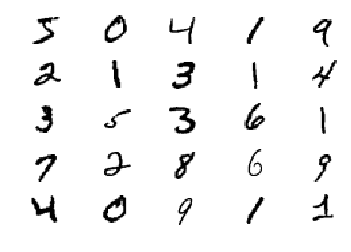

In [4]:
# plot images from the training dataset
for i in range(25):
	# define subplot
	pyplot.subplot(5, 5, 1 + i)
	# turn off axis
	pyplot.axis('off')
	# plot raw pixel data
	pyplot.imshow(trainX[i], cmap='gray_r')
pyplot.show()

<br>
<br>
# Defining the discriminator model

The model must take a sample image from our dataset as input and output a classification prediction as to whether the sample is real or fake.

This is a binary classification problem with following characteristic :
Inputs: Image with one channel and 28×28 pixels in size.
Outputs: Binary classification, likelihood the sample is real (or fake).

The discriminator model has two convolutional layers with 64 filters each, a small kernel size of 3, and larger than normal stride of 2. The model has no pooling layers and a single node in the output layer with the sigmoid activation function to predict whether the input sample is real or fake. The model is trained to minimize the binary cross entropy loss function, appropriate for binary classification.

We will use some best practices in defining the discriminator model, such as the use of LeakyReLU instead of ReLU, using Dropout, and using the Adam version of stochastic gradient descent with a learning rate of 0.0002 and a momentum of 0.5.

The function define_discriminator() below defines the discriminator model and parametrizes the size of the input image.

In [5]:
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [6]:
# define model
model = define_discriminator()

In [7]:
# summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

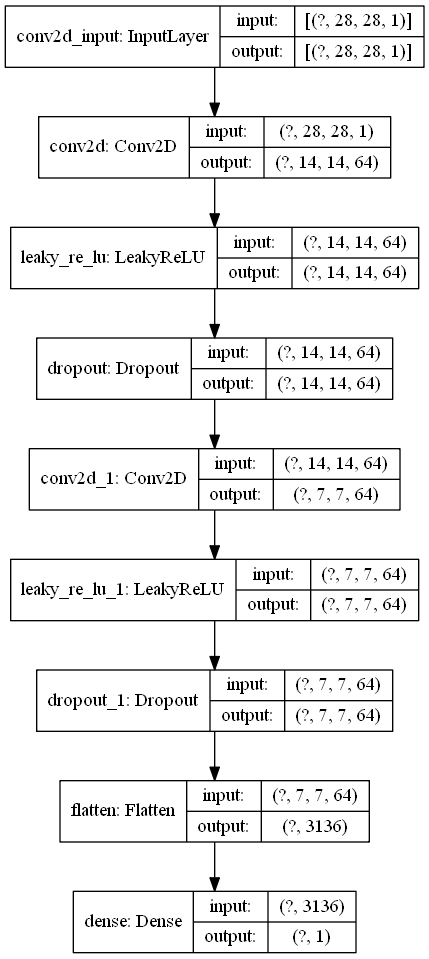

In [8]:
# plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

Creating this plot assumes that the pydot and graphviz libraries are installed. If this is a problem, you can comment out the import statement for the plot_model function and the call to the plot_model() function.
<br>To install pydot and graphviz --
<br>1. pip install pydot
<br>2. pip install graphviz
<br>3. Download graphviz zip file from : https://graphviz.gitlab.io/_pages/Download/Download_windows.html
<br>4. Extract and add "...\graphviz-2.38\release\bin" to windows path variable

# Defining and using the generator model

<br>The generator model is responsible for creating new, fake but plausible images of handwritten digits.

<br>It does this by taking a point from the latent space as input and outputting a square grayscale image.

<br>The latent space is an arbitrarily defined vector space of Gaussian-distributed values, e.g. 100 dimensions. It has no meaning, but by drawing points from this space randomly and providing them to the generator model during training, the generator model will assign meaning to the latent points and, in turn, the latent space, until, at the end of training, the latent vector space represents a compressed representation of the output space, MNIST images, that only the generator knows how to turn into plausible MNIST images.
<br>- Inputs: Point in latent space, e.g. a 100 element vector of Gaussian random numbers.
<br>- Outputs: Two-dimensional square grayscale image of 28×28 pixels with pixel values in \[0,1\].

<br> We will now describe the architecture used for the generator model.

<br>Developing a generator model requires that we transform a vector from the latent space with, 100 dimensions to a 2D array with 28×28 or 784 values.

<br>For this, we use a Dense layer as the first hidden layer that has enough nodes to represent a low-resolution version of the output image. Specifically, an image half the size (one quarter the area) of the output image would be 14×14 or 196 nodes, and an image one quarter the size (one eighth the area) would be 7×7 or 49 nodes.

<br>We don’t just want one low-resolution version of the image; we want many parallel versions or interpretations of the input. This is a pattern in convolutional neural networks where we have many parallel filters resulting in multiple parallel activation maps, called feature maps, with different interpretations of the input. We want the same thing in reverse: many parallel versions of our output with different learned features that can be collapsed in the output layer into a final image. The model needs space to invent, create, or generate.
<br>Therefore, the first hidden layer, the Dense, needs enough nodes for multiple low-resolution versions of our output image, such as 128.
<br> The activations from these nodes can then be reshaped into something image-like to pass into a convolutional layer, such as 128 different 7×7 feature maps.

<br>The next step involves upsampling the low-resolution image to a higher resolution version of the image.

<br>There are two common ways to do this upsampling process, also called deconvolution.

<br>One way is to use an UpSampling2D layer (like a reverse pooling layer) followed by a normal Conv2D layer. The other and perhaps more modern way is to combine these two operations into a single layer, called a Conv2DTranspose. We will use this latter approach for our generator.

<br>The Conv2DTranspose layer can be configured with a stride of (2×2) that will quadruple the area of the input feature maps (double their width and height dimensions). It is also good practice to use a kernel size that is a factor of the stride (e.g. double) to avoid a checkerboard pattern that can be observed when upsampling.

<br>This can be repeated to arrive at our 28×28 output image.

<br>Again, we will use the LeakyReLU with a default slope of 0.2, reported as a best practice when training GAN models.

<br>The output layer of the model is a Conv2D with one filter and a kernel size of 7×7 and ‘same’ padding, designed to create a single feature map and preserve its dimensions at 28×28 pixels. A sigmoid activation is used to ensure output values are in the desired range of \[0,1\].

<br>the generator model is not compiled and does not specify a loss function or optimization algorithm. This is because the generator is not trained directly. We will learn more about this in the next section.

<br>The define_generator() function below implements this and defines the generator model.


In [9]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

We can summarize the model to help better understand the input and output shapes.

In [10]:
# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28, 28, 128)      

We can see that, as designed, the first hidden layer has 6,272 parameters or 128 * 7 * 7, the activations of which are reshaped into 128 7×7 feature maps. The feature maps are then upscaled via the two Conv2DTranspose layers to the desired output shape of 28×28, until the output layer, where a single activation map is output.

A plot of the model is also created and we can see that the model expects a 100-element point from the latent space as input and will generate an image as output.

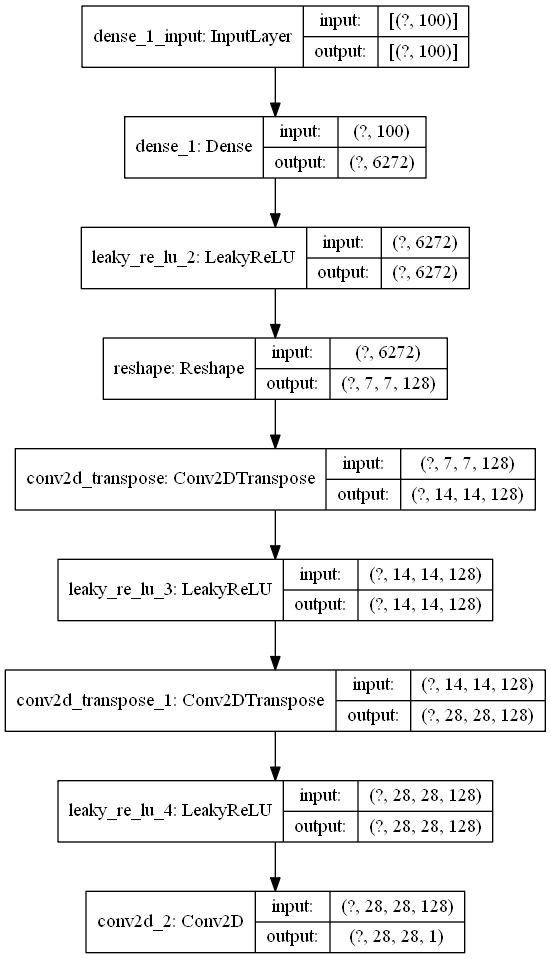

In [11]:
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

<br>We can demonstrate how to use our generator model to generate samples.

<br>The first step is to generate new points in the latent space. We can achieve this by calling the randn() NumPy function for generating arrays of random numbers drawn from a standard Gaussian.

<br>The array of random numbers can then be reshaped into samples, that is n rows with 100 elements per row. The generate_latent_points() function below implements this and generates the desired number of points in the latent space that can be used as input to the generator model.

In [12]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

<br> Next, we can use the generated points as input to the generator model to generate new samples, then plot the samples.

<br>We can use the generate_fake_samples() function below to take the generator model as an argument and use it to generate the desired number of samples by first calling the generate_latent_points() function to generate the required number of points in latent space as input to the model.

<br>The generate_fake_samples() function is listed below and returns both the generated samples and the associated class labels.

In [13]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

<br>We also need to take real samples from our dataset. For sake of continuity we will define the function and explain it right here though it will not be used right now.

<br>We could systematically enumerate all samples in the training dataset, but good training via stochastic gradient descent requires that the training dataset be shuffled prior to each epoch. A simple approach is to select random samples of images from the training dataset.

<br>The generate_real_samples() function below will take the training dataset as an argument and will select a random subsample of images; it will also return class labels for the sample, specifically a class label of 1, to indicate real images.


In [14]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

<br> We will now use the untrained generator model to generate fake images.
<br>Running the code below generates 25 examples of fake MNIST images and visualizes them on a single plot of 5 by 5 images.
<br>As the model is not trained, the generated images are completely random pixel values in \[0, 1\].

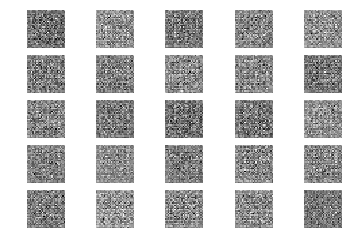

In [15]:
# size of the latent space
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# plot the generated samples
for i in range(n_samples):
	# define subplot
	pyplot.subplot(5, 5, 1 + i)
	# turn off axis labels
	pyplot.axis('off')
	# plot single image
	pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
pyplot.show()

# The composite discriminator and generator model(GAN)

<br>The weights in the generator model are updated based on the performance of the discriminator model.
<br>We will create a new model that combines the generator and discriminator models.

<br>Specifically, a new GAN model can be defined that stacks the generator and discriminator such that the generator receives as input random points in the latent space and generates samples that are fed into the discriminator model directly, classified, and the output of this larger model can be used to update the model weights of the generator.

<br>The discriminator is concerned with distinguishing between real and fake examples, therefore the discriminator model can be trained in a standalone manner on examples of each.

<br>The generator model is only concerned with the discriminator’s performance on fake examples. Therefore, we will mark all of the layers in the discriminator as not trainable when it is part of the GAN model so that they can not be updated and overtrained on fake examples.

<br>When training the generator via this logical GAN model, we want the discriminator to think that the samples output by the generator are real, not fake. Therefore, when the generator is trained as part of the GAN model, we will mark the generated samples as real (class 1).

<br>The discriminator will then classify the generated samples as not real (class 0) or a low probability of being real (0.3 or 0.5). The backpropagation process used to update the model weights will see this as a large error and will update the model weights (i.e. only the weights in the generator) to correct for this error, in turn making the generator better at generating good fake samples.

<br>Let us now clarify the inputs and outputs of the composite GAN model -
<br>- Inputs: Point in latent space, e.g. a 100 element vector of Gaussian random numbers.
<br>- Outputs: Binary classification, likelihood the sample is real (or fake).
<br>The define_gan() function below takes as arguments the already-defined generator and discriminator models and creates the new logical third model subsuming these two models. The weights in the discriminator are marked as not trainable, which only affects the weights as seen by the GAN model and not the standalone discriminator model.

<br>The GAN model then uses the same binary cross entropy loss function as the discriminator and the efficient Adam version of stochastic gradient descent with the learning rate of 0.0002 and momentum 0.5, recommended when training deep convolutional GANs.

In [16]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

<br>The trainable property impacts the model after it is compiled. The discriminator model was compiled with trainable layers, therefore the model weights in those layers will be updated when the standalone model is updated via calls to the train_on_batch() function.

<br>The discriminator model was then marked as not trainable, added to the GAN model, and compiled. In this model, the model weights of the discriminator model are not trainable and cannot be changed when the GAN model is updated via calls to the train_on_batch() function. This change in the trainable property does not impact the training of standalone discriminator model.
More info regarding this can be found on this link : https://keras.io/getting-started/faq/#how-can-i-freeze-keras-layers

In [17]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)

We will create a summary of the composite model.

We can see that the model expects MNIST images as input and predict a single value as output.

In [18]:
# summarize gan model
gan_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


A plot of the model is also created and we can see that the model expects a 100-element point in latent space as input and will predict a single output classification label.

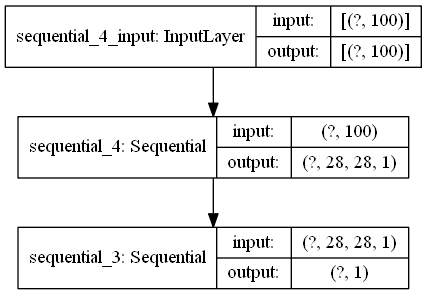

In [19]:
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

# Evaluating GAN model performance

<br>Generally, there are no objective ways to evaluate the performance of a GAN model.

<br>Images must be subjectively evaluated for quality by a human operator. This means that we cannot know when to stop training without looking at examples of generated images. In turn, the adversarial nature of the training process means that the generator is changing after every batch, meaning that once “good enough” images can be generated, the subjective quality of the images may then begin to vary, improve, or even degrade with subsequent updates.

<br>There are three ways to handle this complex training situation.
<br> - Periodically evaluate the classification accuracy of the discriminator on real and fake images.
<br> - Periodically generate many images and save them to file for subjective review.
<br> - Periodically save the generator model.
<br>All three of these actions can be performed at the same time for a given training epoch, such as every five or 10 training epochs. The result will be a saved generator model for which we have a way of subjectively assessing the quality of its output and objectively knowing how well the discriminator was fooled at the time the model was saved.

<br>Training the GAN over many epochs, such as hundreds or thousands of epochs, will result in many snapshots of the model that can be inspected and from which specific outputs and models can be cherry-picked for later use.


<br>We will develop a function to create a plot of the generated samples.
<br>As we are evaluating the discriminator on 100 generated MNIST images, we can plot all 100 images as a 10 by 10 grid. The save_plot() function below implements this, again saving the resulting plot with a unique filename based on the epoch number.

In [20]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

<br>We can define a function called summarize_performance() function that will summarize the performance of the discriminator model. It does this by retrieving a sample of real MNIST images, as well as generating the same number of fake MNIST images with the generator model, then evaluating the classification accuracy of the discriminator model on each sample and reporting these scores.

In [21]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)

# Training the composite discriminator and generator model

<br>We need a function to load and prepare the dataset of real images.

<br>We will use the mnist.load_data() function to load the MNIST dataset and just use the input part of the training dataset as the real images.

<br>The images are 2D arrays of pixels and convolutional neural networks expect 3D arrays of images as input, where each image has one or more channels.

<br>We must update the images to have an additional dimension for the grayscale channel. We can do this using the expand_dims() NumPy function and specify the final dimension for the channels-last image format.

<br>Finally, we must scale the pixel values from the range of unsigned integers in \[0,255\] to the normalized range of \[0,1\].

<br>The load_real_samples() function below implements this.

In [22]:
# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X

<br>Train function for updating the discriminator model and the generator (via the composite model) is written below.

<br>First, the number of batches within an epoch is defined by how many times the batch size divides into the training dataset. We have a dataset size of 60K samples, so with rounding down, there are 234 batches per epoch.

<br>The discriminator model is updated once per batch by combining one half a batch of fake and real examples into a single batch via the vstack() NumPy function. We can also update the discriminator with each half batch separately.

<br>Finally, we report the loss of each batch. It is critical to keep an eye on the loss over batches. The reason for this is that a crash in the discriminator loss indicates that the generator model has started generating vague examples that the discriminator can easily discriminate.


In [23]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

Finally we will use the functions defined above and load the dataset and start training

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)